In [11]:
import pandas as pd

df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
print(df.shape)
print(df.head())
print(df['target'].value_counts())


(7613, 5)
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
target
0    4342
1    3271
Name: count, dtype: int64


In [12]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['clean_text'] = df['text'].apply(clean_text)
print(df[['text', 'clean_text']].head())


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                          clean_text  
0         deed reason earthquake may allah forgive u  
1              forest fire near la ronge sask canada  
2  resident asked shelter place notified officer ...  
3  people receive wildfire evacuation order calif...  
4  got sent photo ruby alaska smoke wildfire pour...  


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['clean_text'])
y = df['target']

print("TF-IDF shape:", X.shape)


TF-IDF shape: (7613, 5000)


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84       874
           1       0.84      0.66      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523

Confusion Matrix:
 [[793  81]
 [219 430]]


In [15]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       874
           1       0.83      0.68      0.75       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523

Confusion Matrix:
 [[783  91]
 [206 443]]


In [16]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(max_iter=1000)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82       874
           1       0.77      0.71      0.73       649

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.78      0.78      1523

Confusion Matrix:
 [[733 141]
 [190 459]]


In [17]:
from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

grid = GridSearchCV(LogisticRegression(max_iter=500), param_grid=params, cv=5, scoring='f1')
grid.fit(X_train, y_train)

best_lr = grid.best_estimator_
y_pred_best = best_lr.predict(X_test)

print("best:", grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))


best: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       874
           1       0.83      0.68      0.75       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523

Confusion Matrix:
 [[783  91]
 [206 443]]


In [18]:
import numpy as np
from scipy.sparse import hstack

keywords_list = ['earthquake', 'flood', 'hurricane', 'wildfire']

def extract_features(text):
    length_words = len(text.split())
    hashtags = text.count('#')
    mentions = text.count('@')
    keyword_flag = int(any(k in text for k in keywords_list))
    return [length_words, hashtags, mentions, keyword_flag]

features = df['clean_text'].apply(extract_features)
features_array = np.array(features.tolist())

X_combined = hstack([X, features_array])
print("Shape after adding new features:", X_combined.shape)


Shape after adding new features: (7613, 5004)


In [19]:
X_train_new, X_test_new, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

lr_model_new = LogisticRegression(max_iter=500)
lr_model_new.fit(X_train_new, y_train)

y_pred_new = lr_model_new.predict(X_test_new)

print("Classification Report:\n", classification_report(y_test, y_pred_new))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_new))


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       874
           1       0.82      0.71      0.76       649

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523

Confusion Matrix:
 [[775  99]
 [188 461]]


In [23]:
import gensim.downloader as api
import numpy as np

glove_vectors = api.load("glove-wiki-gigaword-100")

def tweet_to_vec(text):
    words = text.split()
    vecs = [glove_vectors[word] for word in words if word in glove_vectors]
    if len(vecs) == 0:
        return np.zeros(100)
    return np.mean(vecs, axis=0)

X_glove = np.array(df['clean_text'].apply(tweet_to_vec).tolist())
print("Shape after GloVe embeddings:", X_glove.shape)


Shape after GloVe embeddings: (7613, 100)


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train_glove, X_test_glove, y_train, y_test = train_test_split(X_glove, y, test_size=0.2, random_state=42)

mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
mlp_model.fit(X_train_glove, y_train)

y_pred_mlp = mlp_model.predict(X_test_glove)

print("Classification Report:\n", classification_report(y_test, y_pred_mlp))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mlp))


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.78       874
           1       0.70      0.72      0.71       649

    accuracy                           0.75      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.75      0.75      0.75      1523

Confusion Matrix:
 [[679 195]
 [183 466]]


In [25]:

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

X_train_text, X_test_text, y_train, y_test = train_test_split(df['clean_text'].tolist(), y.tolist(), test_size=0.2, random_state=42)

train_encodings = tokenizer(X_train_text, truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(X_test_text, truncation=True, padding=True, max_length=64)

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TweetDataset(train_encodings, y_train)
test_dataset = TweetDataset(test_encodings, y_test)


In [4]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

class MyDataset(Dataset):
    def __init__(self, texts, labels):
        self.enc = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=128
        )
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = MyDataset(
    train_df["text"].tolist(),
    train_df["target"].tolist()
)

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,0.659800
20,0.570000
30,0.503700
40,0.571900
50,0.454700
60,0.426100
70,0.469200
80,0.564500
90,0.456200
100,0.414200


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1428, training_loss=0.3088969701812381, metrics={'train_runtime': 175.7961, 'train_samples_per_second': 129.918, 'train_steps_per_second': 8.123, 'total_flos': 496358447468688.0, 'train_loss': 0.3088969701812381, 'epoch': 3.0})

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["text"].tolist(),
    train_df["target"].tolist(),
    test_size=0.2,
    random_state=42
)

val_dataset = MyDataset(val_texts, val_labels)

preds_output = trainer.predict(val_dataset)
preds = preds_output.predictions.argmax(-1)

print("Classification Report:\n", classification_report(val_labels, preds))
print("Confusion Matrix:\n", confusion_matrix(val_labels, preds))


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       874
           1       0.97      0.92      0.94       649

    accuracy                           0.95      1523
   macro avg       0.95      0.95      0.95      1523
weighted avg       0.95      0.95      0.95      1523

Confusion Matrix:
 [[855  19]
 [ 54 595]]


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


,precision,recall,f1-score,support
0,0.838074,0.876430,0.856823,874.000000
1,0.822660,0.771957,0.796502,649.000000
accuracy,0.831911,0.831911,0.831911,0.831911
macro avg,0.830367,0.824194,0.826663,1523.000000
weighted avg,0.831506,0.831911,0.831119,1523.000000


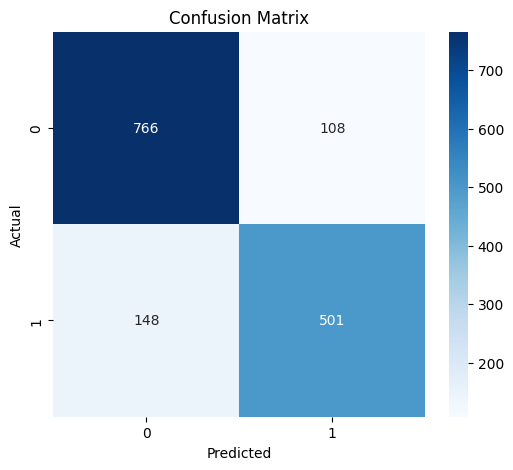

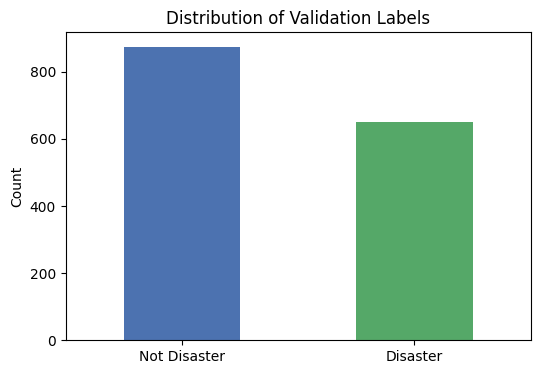

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["text"].tolist(),
    train_df["target"].tolist(),
    test_size=0.2,
    random_state=42
)

val_dataset = MyDataset(val_texts, val_labels)

# Predictions
preds_output = trainer.predict(val_dataset)
preds = preds_output.predictions.argmax(-1)

# Classification Report
report = classification_report(val_labels, preds, output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(report_df.style.background_gradient(cmap="Blues"))

# Confusion Matrix
cm = confusion_matrix(val_labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Distribution Chart
plt.figure(figsize=(6,4))
pd.Series(val_labels).value_counts().sort_index().plot(kind="bar", color=["#4C72B0","#55A868"])
plt.xticks([0,1], ["Not Disaster","Disaster"], rotation=0)
plt.ylabel("Count")
plt.title("Distribution of Validation Labels")
plt.show()


In [7]:
def predict_tweet(tweet):
    model.eval()
    encoding = tokenizer(
        tweet,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )
    encoding = {k: v.to(device) for k, v in encoding.items()}
    
    with torch.no_grad():
        output = model(**encoding)
        pred = torch.argmax(output.logits, dim=1).item()
    
    return "Disaster" if pred == 1 else "Not Disaster"

tweet_input = input("tweet: ")
prediction = predict_tweet(tweet_input)
print("Prediction:", prediction)


tweet:  Floods in downtown are getting worse


Prediction: Disaster
